In [ ]:
library(tracebind)
library(tidyverse)
library(patchwork)
library(IRanges)
library(pbmcapply)
library(MASS)
library(gtools)
library(foreach)
library(doParallel)
library(GenomicRanges)
library(data.table)
library(reticulate)
library(BSgenome.Hsapiens.UCSC.hg38)
use_condaenv("base")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
  

In [ ]:
setwd("/home/mnt/weka/nzh/team/woodsqu2/nzhanglab/project/linyx/footprints/github")


### Load data and preprocessing (obtain counts and predicted bias)

#### load subsetted peaks

In [ ]:
regionsBed = read.table("data/footprints_identification/peaks_region_subset.txt") ### peak regions


#### predict bias by the sample-specific models trained in the tutorial of finetunning 

In [ ]:
get_bias(regionsBed, ### peak file
         referenceGenome = 'hg38', ### reference genome
         save_path = paste0(getwd(), '/data/footprints_identification/freezed_finetuned_subset_'), ### save path
         model_path = 'data/shared/', ### path to the Tn5 model
         model_use = 'Tn5_NN_model_Control_6_freezed_finetuned.h5' ### name of Tn5 model
         )


#### Get insertions for each peak and cell type from fragment files 

In [9]:
metadata = read.csv(paste0("data/footprints_identification/bcanno.csv"))
barcodeGroups = metadata[c('barcode', 'celltype')]
frags_path = "data/footprints_identification/atac_fragments_subset.tsv.gz" ### the fragment has been downsampled, only containing peaks_region_subset
counts = get_count(frags_path, ### path to fragment file
                   regionsBed, ### peak file
                   barcodeGroups = barcodeGroups, ### cells of interest with grouping information
                   chunkSize = 6000)
saveRDS(counts, 'data/footprints_identification/counts_subset.rds')


Make 1bp step .. 
Reformating counts data into a list (each element is data for a region) ..
[1] "Re-organizing data into lists"
[1] "2025-09-01 13:58:32.867826 Processing chunk 1 out of 1 chunks"
Generating matrix of counts for group BCELL..
Generating matrix of counts for group DCT1..
Generating matrix of counts for group DCT2_PC..
Generating matrix of counts for group ENDO..
Generating matrix of counts for group FIB_VSMC_MC..
Generating matrix of counts for group ICA..
Generating matrix of counts for group ICB..
Generating matrix of counts for group MONO..
Generating matrix of counts for group PCT..
Generating matrix of counts for group PEC..
Generating matrix of counts for group PODO..
Generating matrix of counts for group PST..
Generating matrix of counts for group PT_PROM1..
Generating matrix of counts for group PT_VCAM1..
Generating matrix of counts for group TAL..
Generating matrix of counts for group TCELL..
  |==================================================================

### Predict footprints for each peak

#### Load predicted bias and insertions

In [6]:
counts = readRDS("data/footprints_identification/counts_subset.rds")
pred_bias = read.table("data/footprints_identification/freezed_finetuned_subset_pred_bias.txt")


#### Create a dataframe containing predicted bias, insertions for cell-type-specific pseudobulk

##### Take the first peak for PCT cells as an example 

In [7]:
i=1
bardata = get_bardata(counts = counts, ### insertion file
                      regionsBed = regionsBed, ### peak regions
                      bias = pred_bias[i, 1:length(regionsBed$start[i]:regionsBed$end[i])], ### the predicted bias
                      i = i, ### the index of peak in peak regions
                      groupIDs = c('PCT', 'PT_VCAM1')) ### celltype/group of interest


In [9]:
head(bardata)

,position,Tn5Insertion,pred_bias
,<dbl>,<dbl>,<dbl>
1,26034987,2,1.57610323
2,26034988,1,1.54135270
3,26034989,0,0.28078059
4,26034990,1,2.42033828
5,26034991,0,0.09140788
6,26034992,0,0.07579656


#### Visualize the insertions per base pair

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_rect()`).”


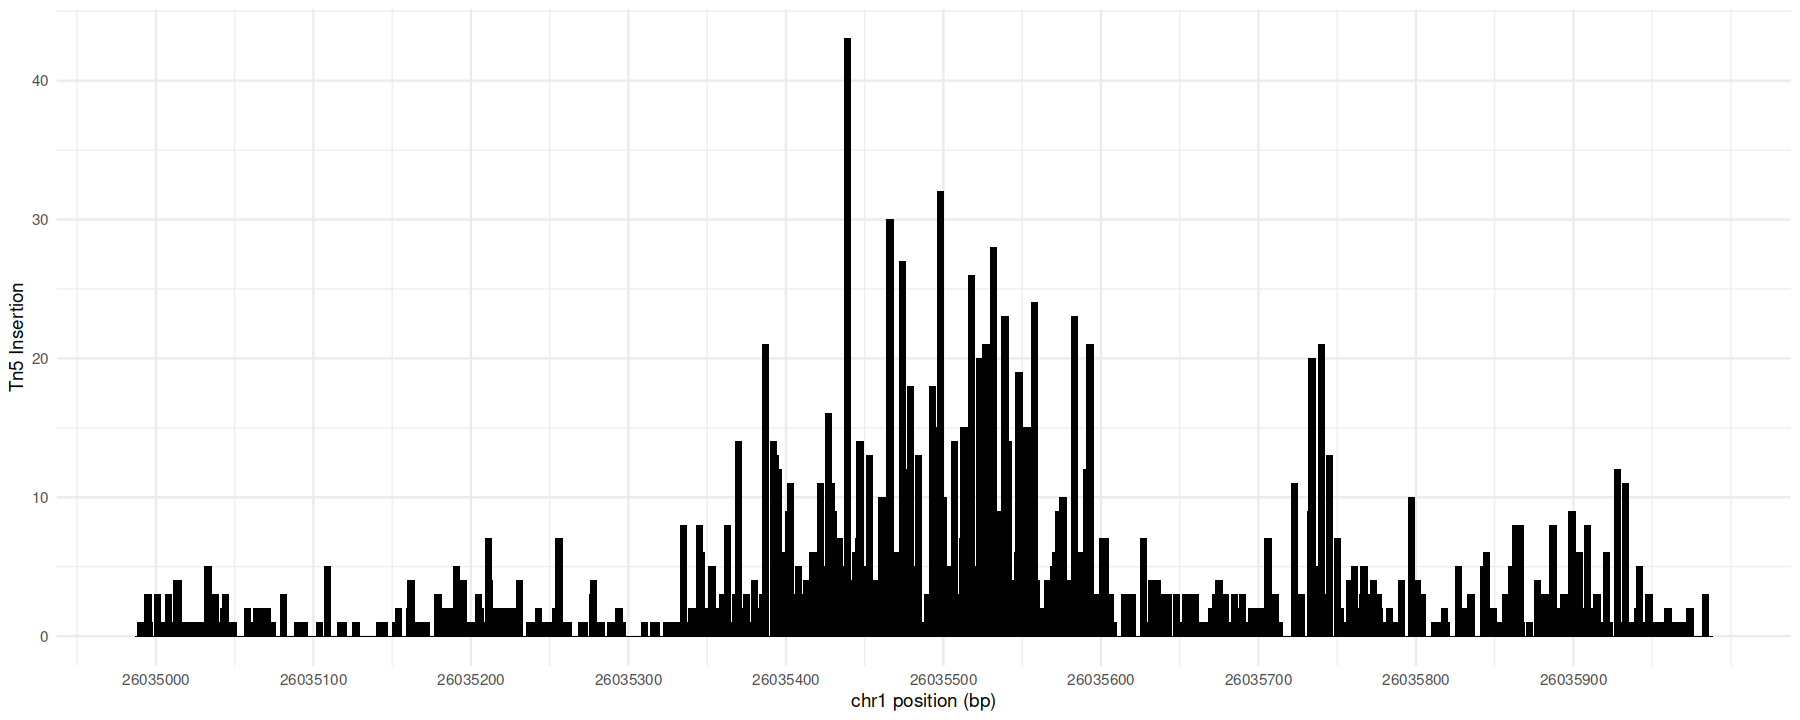

In [10]:
options(repr.plot.width=15, repr.plot.height=6)
Tn5_plot = plot_insertions(bardata$Tn5Insertion, 
                             positions = bardata$position, 
                             chr = regionsBed$chr[i])
Tn5_plot


#### Run footprint prediction

In [11]:
footprinting_results = NB_footprintings(Tn5Insertion = bardata$Tn5Insertion, ### insertions 
                                          pred_bias = bardata$pred_bias, ### Tn5 bias
                                          positions = bardata$position, ### positions
                                          p.adjust.method = 'BH', ### methods of multiple test adjustment 
                                          nCores = 2)  ### number of cores

#### The output contains two matrix: pvalue and effect size matrix. 

In [12]:
names(footprinting_results)

[1] "pval"        "effect_size"

#### The matrix contains pvalues/effect sizes for each base pair across different center sizes.

In [13]:
head(footprinting_results[['pval']])

,4,6,8,10,12,14,16,18,20,22,⋯,182,184,186,188,190,192,194,196,198,200
26034987,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
26034988,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
26034989,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
26034990,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
26034991,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
26034992,1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1


#### Visualize the -log10 pvalues and effect size for each base pair and center size

In [14]:
p_value_matrix = footprinting_results[['pval']]
effect_size_matrix = footprinting_results[['effect_size']]
  
p_value_plot_1 = plot_multiscale_logp(p_value_matrix, 
                                      regionsBed$chr[i])  ### visualize -log10 p-value matrix
p_value_plot_2 = plot_multiscale_logp(p_value_matrix, 
                                      regionsBed$chr[i],
                                      scale = TRUE) ### visualize -log10 p-value matrix, max at 2
effect_size_plot_1 = plot_multiscale_effectsize(effect_size_matrix = effect_size_matrix, 
                                                p_value_matrix = p_value_matrix, 
                                                chr = regionsBed$chr[i]) ### visualize effect size matrix
effect_size_plot_2 = plot_multiscale_effectsize(effect_size_matrix = effect_size_matrix, 
                                                p_value_matrix = p_value_matrix,
                                                chr = regionsBed$chr[i], 
                                                scale = TRUE) ### visualize effect size matrix, making effect size of insignificant regions 0
  

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_rect()`).”
Warning message:
“Removed 2198 rows containing missing values or values outside the scale range
(`geom_tile()`).”
Warning message:
“Removed 198 rows containing missing values or values outside the scale range
(`geom_tile()`).”


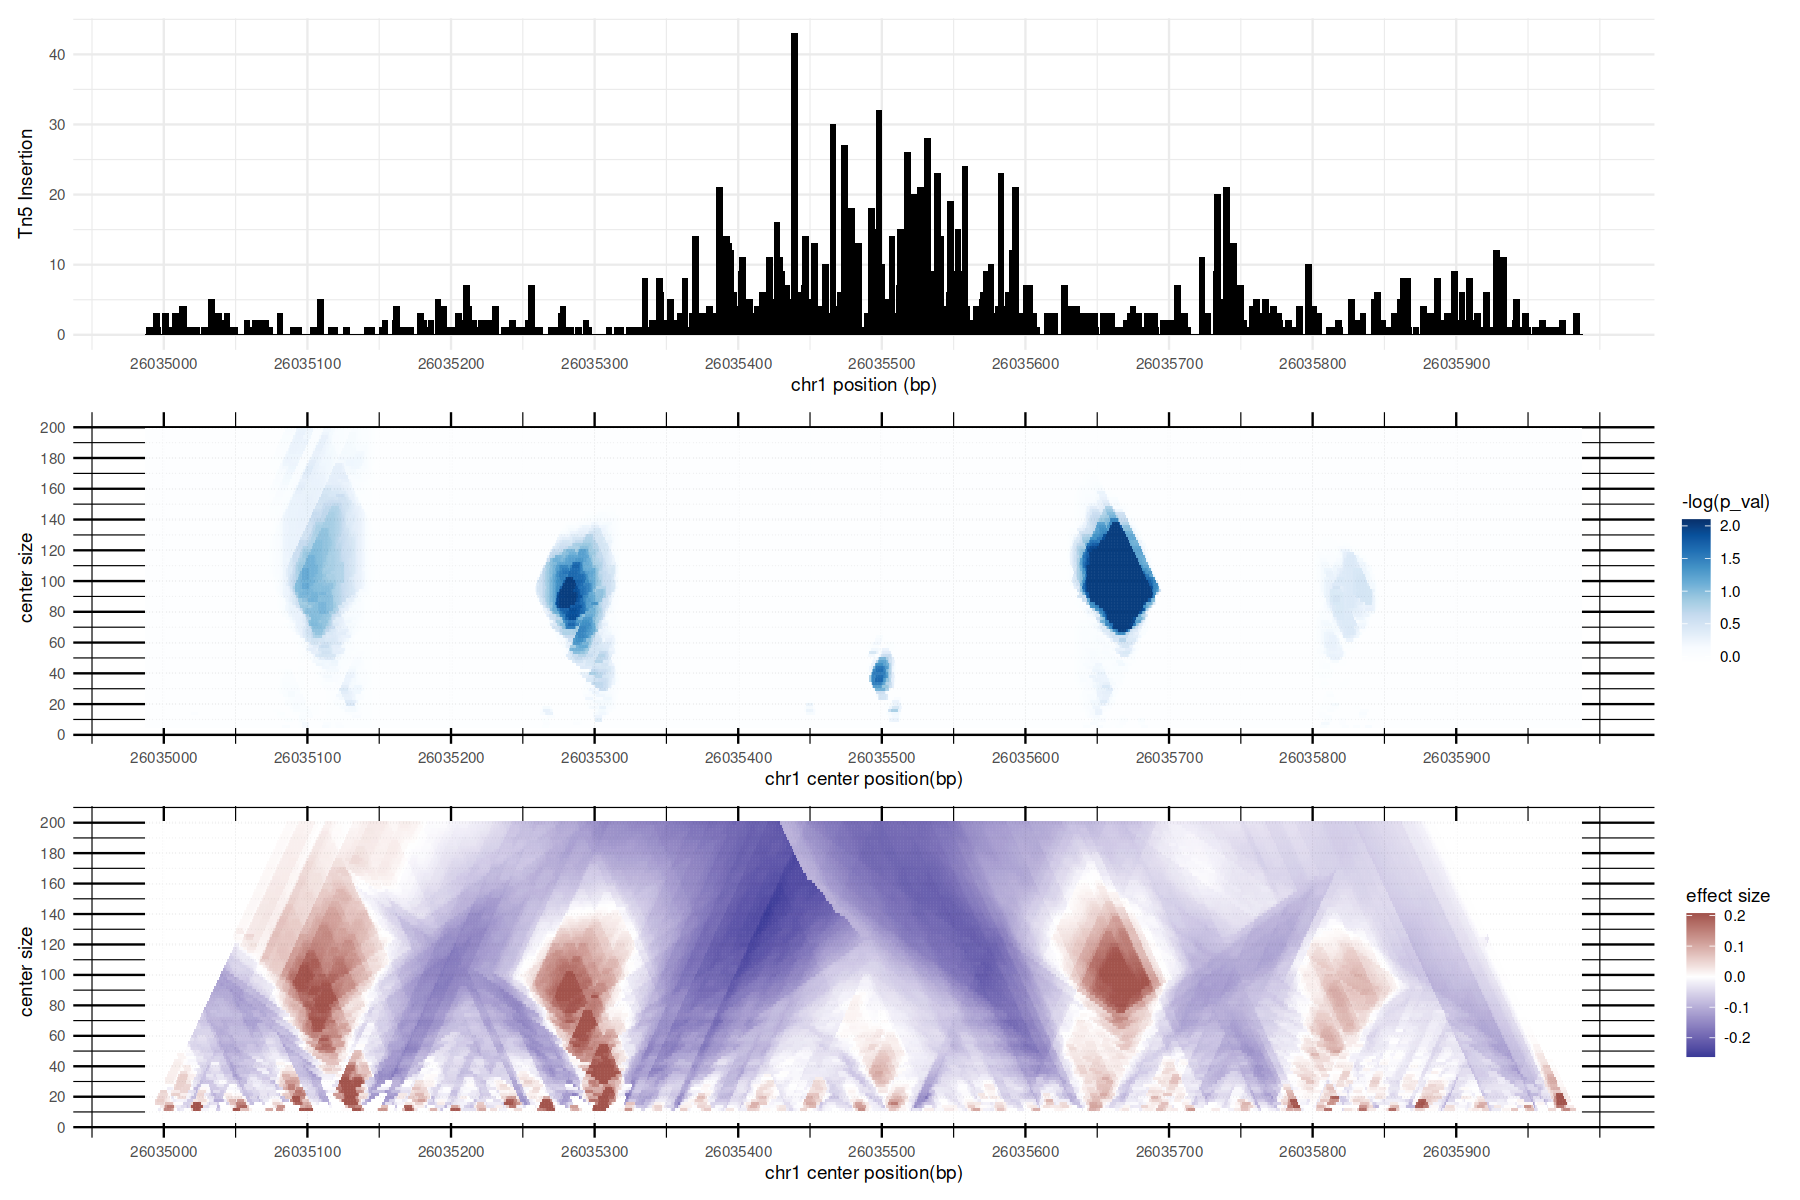

In [15]:
options(repr.plot.width=15, repr.plot.height=10)
p1 = Tn5_plot/p_value_plot_1/effect_size_plot_1
p2 = Tn5_plot/p_value_plot_2/effect_size_plot_1
p2


#### Identify non-overlapping footprints. 

##### There are two methods for identifying footprints, both of which search for non-overlapping regions with the minimum p-values. After footprint detection, binding_sites_pval uses the minimum p-value to determine the precise base-pair width and position, while binding_sites_effect_size uses the maximum effect size for this refinement.

In [16]:
binding_sites_pvals = binding_sites_pval(p_value_matrix, 
                                         pval_threshold = 0.05, ### pval threshold for reported binding sites
                                         width_threshold = 10) ### width threshold for reported binding sites


In [17]:
binding_sites_pvals

width,position,minus_log_p_value
<dbl>,<dbl>,<dbl>
90,26035673,12.893062
88,26035279,4.192452
36,26035498,3.322057
96,26035099,2.310408


In [51]:
binding_sites_pvals


width,position,minus_log_p_value
<dbl>,<dbl>,<dbl>
90,26035673,12.893062
88,26035279,4.192452
36,26035498,3.322057
96,26035099,2.310408


In [52]:
binding_sites_effect_sizes = binding_sites(p_value_matrix, 
                                                       effect_size_matrix, 
                                                       pval_threshold = 0.05, ### pval threshold reported binding sites
                                                       width_threshold = 10) ### width threshold for reported binding sites


In [53]:
binding_sites_effect_sizes


width,position,minus_log_p_value,effect_size,position_effect_size,width_effect_size,pval_effect_size
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
90,26035673,12.893062,0.2618918,26035674,94,11.869268
88,26035279,4.192452,0.2363680,26035290,64,2.637390
36,26035498,3.322057,0.1048684,26035499,36,3.257870
96,26035099,2.310408,0.2493431,26035113,80,1.990073


### Mitochondrial in-sample fdr controls

#### Load logp computed from the tutorial of finetunning 

In [19]:
logp_threshold = read.table("data/mitochondria/logp_threshold.txt")
head(logp_threshold) 


,count,threshold,smoothed_threshold
,<int>,<dbl>,<dbl>
0.1,43308,0.01970677,0.01970677
0.3,39819,0.01951825,0.01951825
0.5,37926,0.01968817,0.01881848
0.7,35375,0.01715309,0.01761181
0.9,33525,0.01802611,0.01677818
1.1,30915,0.01367343,0.01631057


In [20]:
### get average insertions of flanking regions 
for (index in 1:dim(binding_sites_pvals)[1]){
    positions_1 = (binding_sites_pvals$position[index] - binding_sites_pvals$width[index]/2 - 1):(binding_sites_pvals$position[index] - 1 - binding_sites_pvals$width[index]*3/2)
    positions_2 = (binding_sites_pvals$position[index] + binding_sites_pvals$width[index]/2 + 1):(binding_sites_pvals$position[index] + 1 + binding_sites_pvals$width[index]*3/2)
    mean_coverage = min(mean(bardata[bardata$position %in% positions_1, 'Tn5Insertion']), 
                        mean(bardata[bardata$position %in% positions_2, 'Tn5Insertion']))
        
    binding_sites_pvals[index, 'mean_coverage'] = mean_coverage
}
head(binding_sites_pvals)


width,position,minus_log_p_value,mean_coverage
<dbl>,<dbl>,<dbl>,<dbl>
92,26035674,12.807111,1.9139785
36,26035498,5.188890,5.4594595
88,26035279,4.134399,0.8202247
96,26035099,2.651325,0.7187500


In [21]:
### obtain sample-specific threshold for each binding sites by their flanking average insertions
binding_sites_pvals$threshold = apply(binding_sites_pvals, 1, function(x)
    logp_threshold$smoothed_threshold[which.min(abs(x['mean_coverage'] - as.numeric(rownames(logp_threshold))))])
head(binding_sites_pvals)
                                              

width,position,minus_log_p_value,mean_coverage,threshold
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
92,26035674,12.807111,1.9139785,0.02008514
36,26035498,5.188890,5.4594595,1.53934546
88,26035279,4.134399,0.8202247,0.01677818
96,26035099,2.651325,0.7187500,0.01761181
